<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [105]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
import os
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

Reading original data

In [2]:
PATH_TO_DATA = ('../../data/alice_competition')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

site_columns, time_columns = [[c for c in train_df.columns if s in c] for s in ['site', 'time']]

Separate target feature 

In [3]:
y = train_df['target']

Parse datetimes, sort by time1

In [4]:
train_df[time_columns] = train_df[time_columns].apply(pd.to_datetime)
test_df[time_columns] = test_df[time_columns].apply(pd.to_datetime)
train_df['time_last'] = train_df[time_columns].apply(max, axis=1)
test_df['time_last'] = test_df[time_columns].apply(max, axis=1)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

Load sites dictionary, transform sites

In [5]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
train_df[site_columns] = train_df[site_columns].fillna(0).astype('int')
test_df[site_columns] = test_df[site_columns].fillna(0).astype('int')

# Load websites dictionary
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), "rb") as input_file:
    sites_dict = pickle.load(input_file)

site_by_idx = {v: k for k, v in sites_dict.items()}

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(sites_dict.keys()), index=list(sites_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


## Explore dataset

In [6]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,target,time_last
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,0,NaT,0,NaT,0,NaT,0,NaT,0,2013-01-12 08:05:57
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,0,NaT,0,NaT,0,NaT,0,NaT,0,2013-01-12 09:07:09
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,2013-01-12 08:50:22


123776 visits of site idx=21 address  www.google.fr
122730 visits of site idx=0 address  None
87619 visits of site idx=23 address  www.google.com
77055 visits of site idx=782 address  annotathon.org
58258 visits of site idx=22 address  apis.google.com
54094 visits of site idx=29 address  www.facebook.com
46405 visits of site idx=167 address  www.bing.com
43841 visits of site idx=780 address  blast.ncbi.nlm.nih.gov
38194 visits of site idx=778 address  www.ncbi.nlm.nih.gov
36085 visits of site idx=52 address  clients1.google.com


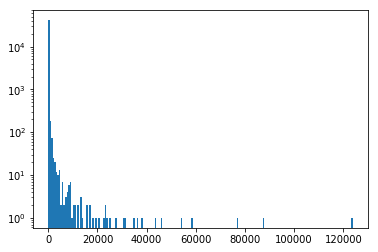

In [7]:
# unique sites
sites, sites_counts = np.unique(train_df[site_columns].values, return_counts=True)
f = plt.hist(sites_counts[1:], log=True, bins=200)   # drop nan

top_n = 10
for idx, count in sorted(zip(sites, sites_counts), key=lambda x: -x[1])[:top_n]:
    print("{} visits of site idx={} address  {}".format(count, idx, site_by_idx.get(idx)))

1382 visits for Alice of site idx=77 address  i1.ytimg.com
1354 visits for Alice of site idx=80 address  s.youtube.com
1307 visits for Alice of site idx=76 address  www.youtube.com
897 visits for Alice of site idx=29 address  www.facebook.com
857 visits for Alice of site idx=21 address  www.google.fr
609 visits for Alice of site idx=81 address  r4---sn-gxo5uxg-jqbe.googlevideo.com
522 visits for Alice of site idx=22 address  apis.google.com
522 visits for Alice of site idx=879 address  r1---sn-gxo5uxg-jqbe.googlevideo.com
451 visits for Alice of site idx=75 address  s.ytimg.com
447 visits for Alice of site idx=82 address  r2---sn-gxo5uxg-jqbe.googlevideo.com


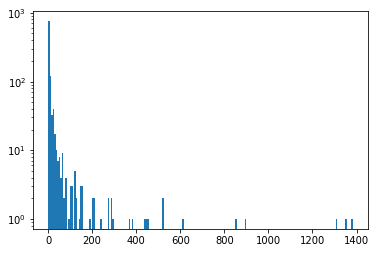

In [9]:
# unique sites for Alice
# unique sites
sites, sites_counts = np.unique(train_df.loc[y == 1, site_columns].values, return_counts=True)
f = plt.hist(sites_counts[1:], log=True, bins=200)   # drop nan

top_n = 10
for idx, count in sorted(zip(sites, sites_counts), key=lambda x: -x[1])[:top_n]:
    print("{} visits for Alice of site idx={} address  {}".format(count, idx, site_by_idx.get(idx)))

## Add features based on the session start time / end time / duration: 
hour, whether it's morning, day or night and so on.

In [10]:
# day of week, is weekend; train_df.groupby('time1_weekday').size()
for df in [train_df, test_df]:
    df['time1_weekday'] = df['time1'].apply(lambda dt: dt.date().weekday())
    df['time1_is_weekend'] = df['time1_weekday'].isin((5,6)).astype(int)
    df['time1_weekday_cos'] = np.cos(df['time1_weekday'] * 2 * np.pi / 7)
    df['time1_weekday_sin'] = np.sin(df['time1_weekday'] * 2 * np.pi / 7)


    # hour of day, part of day?
    df['time1_hour'] = df['time1'].apply(lambda dt: dt.hour)
    df['time1_hour_cos'] = np.cos(df['time1_hour'] * 2 * np.pi / 24)
    df['time1_hour_sin'] = np.sin(df['time1_hour'] * 2 * np.pi / 24)
    df['time1_hour_popular'] = df['time1_hour'].isin((12, 13, 16, 17, 18)).astype(int)

    # duration of session
    df['session_duration'] = (df['time_last'] - df['time1']).apply(lambda x: x.total_seconds())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc20b9f0fd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc20a094470>], dtype=object)

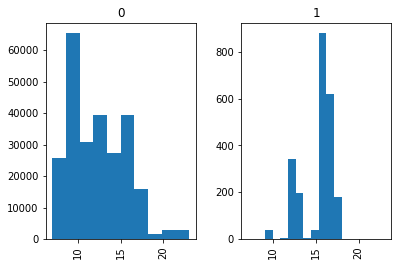

In [11]:
# hour of day by target
train_df.hist('time1_hour', by='target', sharex=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc20b74e7b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc20a2eebe0>], dtype=object)

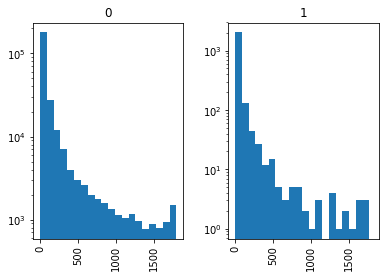

In [12]:
# duration by target
train_df.hist('session_duration', by='target', sharex=True, log=True, bins=20)

## Add "sites in Alice's top-N" features

In [13]:
sites, alice_counts = np.unique(train_df[y == 1][site_columns], return_counts=True)

from collections import Counter

sites_cnt = Counter()
for site, alice_count in zip(sites, alice_counts):
    if site != 0:
        sites_cnt[site] = alice_count

In [14]:
for df in [train_df, test_df]:
    for top_n in np.logspace(0, 8, 9, base=2):
        top_sites = [idx for idx, _ in sites_cnt.most_common(int(top_n))]

        isin_alice = df[site_columns].isin(top_sites)
        df['alice_any_top_{}'.format(top_n)] = isin_alice.any(axis=1).astype(int)
        not_nan = (df[site_columns] > 0).sum(axis=1)
        df['alice_part_top_{}'.format(top_n)] = isin_alice.sum(axis=1) / not_nan

## Save results

In [15]:
#train_df.to_csv(os.path.join(PATH_TO_DATA, 'train_sessions_time_top_n.csv'))
#test_df.to_csv(os.path.join(PATH_TO_DATA, 'test_sessions_time_top_n.csv'))

## Build Tf-Idf features based on sites (idxs and addresses)
[TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

Одна сессия -- это документ. один сайт (его индекс или адрес) -- это терм

In [55]:
%%time
# join site addresses to dataframes
for df in [train_df, test_df]:
    for site_col in site_columns:
        addresses = sites_dict.loc[df[site_col]]
        addresses.index = df.index
        df[site_col + '_address'] = addresses
site_address_columns = [c + '_address' for c in site_columns]

CPU times: user 2.25 s, sys: 32 ms, total: 2.28 s
Wall time: 2.28 s


In [56]:
%%time
# join strings
train_df['sites_idxs_merged'] = train_df[site_columns].apply(
    lambda x: " ".join([str(int(v)) for v in x if not np.isnan(v)]), 
    axis=1
)
train_df['sites_addresses_merged'] = train_df[site_address_columns].apply(
    lambda x: " ".join([v for v in x if isinstance(v, str)]), 
    axis=1
)

test_df['sites_idxs_merged'] = test_df[site_columns].apply(
    lambda x: " ".join([str(int(v)) for v in x if not np.isnan(v)]), 
    axis=1
)
test_df['sites_addresses_merged'] = test_df[site_address_columns].apply(
    lambda x: " ".join([v for v in x if isinstance(v, str)]), 
    axis=1
)

CPU times: user 33.3 s, sys: 136 ms, total: 33.4 s
Wall time: 33.4 s


In [57]:
%%time
# tf-idf on site idxs
tf_idf_idxs = TfidfVectorizer(ngram_range=(1, 3), max_features=100000)
tf_idf_idxs.fit(pd.concat([train_df['sites_idxs_merged'], test_df['sites_idxs_merged']]))    # not very honest

train_df_tf_idf_on_site_idxs = tf_idf_idxs.transform(train_df['sites_idxs_merged'])
test_df_tf_idf_on_site_idxs = tf_idf_idxs.transform(test_df['sites_idxs_merged'])

CPU times: user 25.4 s, sys: 184 ms, total: 25.6 s
Wall time: 25.6 s


In [58]:
%%time
# tf-idf on site addresses
site_address_columns = [c + '_address' for c in site_columns]
tf_idf_addr = TfidfVectorizer(ngram_range=(3, 6), max_features=100000)
tf_idf_addr.fit(pd.concat([train_df['sites_addresses_merged'], test_df['sites_addresses_merged']]))    # not very honest

train_df_tf_idf_on_site_addr = tf_idf_addr.transform(train_df['sites_addresses_merged'])
test_df_tf_idf_on_site_addr = tf_idf_addr.transform(test_df['sites_addresses_merged'])

CPU times: user 1min 35s, sys: 2.03 s, total: 1min 37s
Wall time: 1min 37s


## Calculate sparce matrix for "site N was visited"

In [24]:
full_sites = pd.concat([train_df.drop('target', axis=1), test_df])[site_columns]
idx_split = train_df.shape[0]

sites_flatten = full_sites.values.flatten()
sites_sparse = csr_matrix(([1] * sites_flatten.shape[0], sites_flatten,
                             range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

train_df_sparce = sites_sparse[:idx_split]
test_df_sparce = sites_sparse[idx_split:]

## Scale and combine features
(you'll need `scipy.sparse.hstack`)

In [26]:
# filter only numeric columns for prediction
X_columns = [c for c, t in zip(train_df.columns, train_df.dtypes) if t in [np.int64, np.float64] and c != 'target']
print("dropping: ", set(train_df.columns) - set(X_columns))
print("learning on:", X_columns)

X_learn, y_learn = train_df[X_columns], train_df['target']
X_test = test_df[X_columns]

dropping:  {'time5', 'target', 'site4_address', 'site9_address', 'time_last', 'site6_address', 'time10', 'sites_addresses_merged', 'time6', 'site5_address', 'site7_address', 'time3', 'site3_address', 'time4', 'site1_address', 'site10_address', 'time2', 'site8_address', 'time9', 'site2_address', 'time8', 'time1', 'sites_idxs_merged', 'time7'}
learning on: ['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10', 'time1_weekday', 'time1_is_weekend', 'time1_weekday_cos', 'time1_weekday_sin', 'time1_hour', 'time1_hour_cos', 'time1_hour_sin', 'time1_hour_popular', 'session_duration', 'alice_any_top_1.0', 'alice_part_top_1.0', 'alice_any_top_2.0', 'alice_part_top_2.0', 'alice_any_top_4.0', 'alice_part_top_4.0', 'alice_any_top_8.0', 'alice_part_top_8.0', 'alice_any_top_16.0', 'alice_part_top_16.0', 'alice_any_top_32.0', 'alice_part_top_32.0', 'alice_any_top_64.0', 'alice_part_top_64.0', 'alice_any_top_128.0', 'alice_part_top_128.0', 'alice_any_top_256.0', 'al

In [27]:
# scale datasets
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(pd.concat([X_learn, X_test]))

X_learn = scaler.transform(X_learn)
X_test = scaler.transform(X_test)

In [28]:
# combine with simple "site visited" sparce table
X_learn = hstack([X_learn, train_df_sparce])
X_test = hstack([X_test, test_df_sparce])

In [29]:
# combine with tf-idf
X_learn = hstack([X_learn, train_df_tf_idf_on_site_idxs, train_df_tf_idf_on_site_addr])
X_test = hstack([X_test, test_df_tf_idf_on_site_idxs, test_df_tf_idf_on_site_addr])

## Feature selection

In [31]:
from sklearn.feature_selection import SelectPercentile, chi2, f_classif, mutual_info_classif, VarianceThreshold

# ('chi2', chi2) not working with negative values
# ('mut_info', mutual_info_classif) soooo sloooow

lr_grid = GridSearchCV(
    LogisticRegression(random_state=17), 
    {'C': np.logspace(-2, 2, 5)}, cv=5, n_jobs=-1, scoring='roc_auc'
)
#print('original', lr_grid.fit(X_learn, y_learn).best_score_)
selectors, X_learn_by_sel = {}, {}

def get_score_by_selector(selector):
    X_learn_sel = selector.fit_transform(X_learn, y_learn)
    grid = lr_grid.fit(X_learn_sel, y_learn)
    return grid.best_score_, grid.best_estimator_

print('var, 0', get_score_by_selector(VarianceThreshold(0)))

#print('var, 0.01', get_score_by_selector(VarianceThreshold(0.01)))

#print('var, 0.1', get_score_by_selector(VarianceThreshold(0.1)))

#print('var, 1', get_score_by_selector(VarianceThreshold(1)))


#print('f_classif, 0.0001', get_score_by_selector(SelectPercentile(f_classif, 0.0001)))
# 0.52

#print('f_classif, 0.001', get_score_by_selector(SelectPercentile(f_classif, 0.001)))

#print('f_classif, 0.01', get_score_by_selector(SelectPercentile(f_classif, 0.01)))


Process ForkPoolWorker-63:
Process ForkPoolWorker-38:
Process ForkPoolWorker-41:
Process ForkPoolWorker-35:
Process ForkPoolWorker-60:
Process ForkPoolWorker-40:
Process ForkPoolWorker-42:
Process ForkPoolWorker-36:
Process ForkPoolWorker-34:
Process ForkPoolWorker-37:
Process ForkPoolWorker-39:
Process ForkPoolWorker-33:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-61:
Traceback (most recent call last):
  File "/home/lenavolzhina/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-64:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-59:
Process ForkPoolWorker-62:
  File "/home/lenavolzhina/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/lenavolzhina/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
T

  File "/home/lenavolzhina/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
KeyboardInterrupt
  File "/home/lenavolzhina/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
  File "/home/lenavolzhina/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
  File "/home/lenavolzhina/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/home/lenavolzhina/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/lenavolzhina/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/lenavolzhina/anaconda3/lib/python3.6/mul

KeyboardInterrupt: 

Process ForkPoolWorker-44:
Traceback (most recent call last):
  File "/home/lenavolzhina/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lenavolzhina/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lenavolzhina/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/lenavolzhina/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
KeyboardInterrupt


In [40]:
selector = VarianceThreshold(2)
X_learn_sel = selector.fit_transform(X_learn, y_learn)
print(X_learn_sel.shape[0])

253561


In [44]:
X_learn

<253561x248408 sparse matrix of type '<class 'numpy.float64'>'
	with 29390540 stored elements in COOrdinate format>

## Perform cross-validation with logistic regression.

In [89]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=ratio, random_state=seed, shuffle=True)
    #print(X_train.shape, y_train.shape)
    
    # Classifier training
    clf = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X_train, y_train)
    #clf = RandomForestClassifier(n_estimators=100, max_features=500, max_depth=50, n_jobs=-1, random_state=seed).fit(X_train, y_train)
    
    # Prediction for validation set
    y_pred = clf.predict_proba(X_val)[:, 1]
    
    # Calculate the quality
    score = roc_auc_score(y_val, y_pred)
    
    return score

In [82]:
X_learn.shape

(253561, 248408)

In [86]:
%%time
get_auc_lr_valid(X_learn, y_learn, ratio=0.9)

CPU times: user 6min 26s, sys: 3.75 s, total: 6min 29s
Wall time: 18 s


0.9543722352847408

In [79]:
123

123

## Make prediction for the test set and form a submission file.

In [20]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [99]:
sel = selectors[('f_classif', 0.1)]
X_learn_sel = sel.transform(X_learn)
X_test_sel = sel.transform(X_test)

In [102]:
#lr = LogisticRegression(C=1.0, random_state=17).fit(X_learn, y_learn)
clf = LogisticRegression(C=1.0, n_jobs=-1, random_state=17).fit(X_learn_sel, y_learn)

y_test = clf.predict_proba(X_test_sel)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'submissions/submission_5_f_classif_0.1.csv')

92.076